# Import data and necessary packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sktime.distances.elastic_cython import dtw_distance

header = ["unit num", "cycle", "op1", "op2", "op3"]
for i in range(0, 21):
    name = "sens"
    name = name + str(i+1)
    header.append(name)

#df_RUL_001 = pd.read_csv('Dataset\RUL_FD001.txt', delimiter = " ")
df_train_001 = pd.read_csv('Dataset\\train_FD001.txt', sep='\s+', header=None, names=header)
# df_train_001.head(10)

In [2]:
# df_train_001.info()

# Plot cycle at which failure occurs

In [3]:
# to show avg cycle at which event occurred
avg_cycle = []
for i in range(1, 101):
    df_engine = df_train_001[df_train_001['unit num'] == i]
    max_cycle = df_engine.loc[df_engine['cycle'].idxmax()]
    avg_cycle.append(max_cycle["cycle"].astype(int))

In [4]:
print(stats.describe(avg_cycle))

DescribeResult(nobs=100, minmax=(128, 362), mean=206.31, variance=2147.6504040404043, skewness=1.0159342583415127, kurtosis=1.113867529578351)


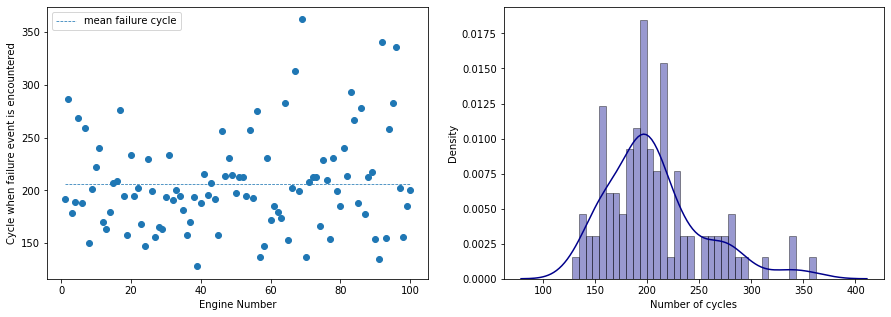

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(range(1, 101), avg_cycle, marker='o')
axes[0].plot(range(1, 101), [stats.describe(avg_cycle)[2]]*100, linestyle='dashed', linewidth = 0.75, label='mean failure cycle')
axes[0].set_xlabel("Engine Number")
axes[0].set_ylabel("Cycle when failure event is encountered")
axes[0].legend()

ax = sns.distplot(avg_cycle, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1.5}, ax=axes[1])
ax.set(xlabel='Number of cycles', ylabel='Density')
plt.show()

# Plot variation of signals from selected sensor

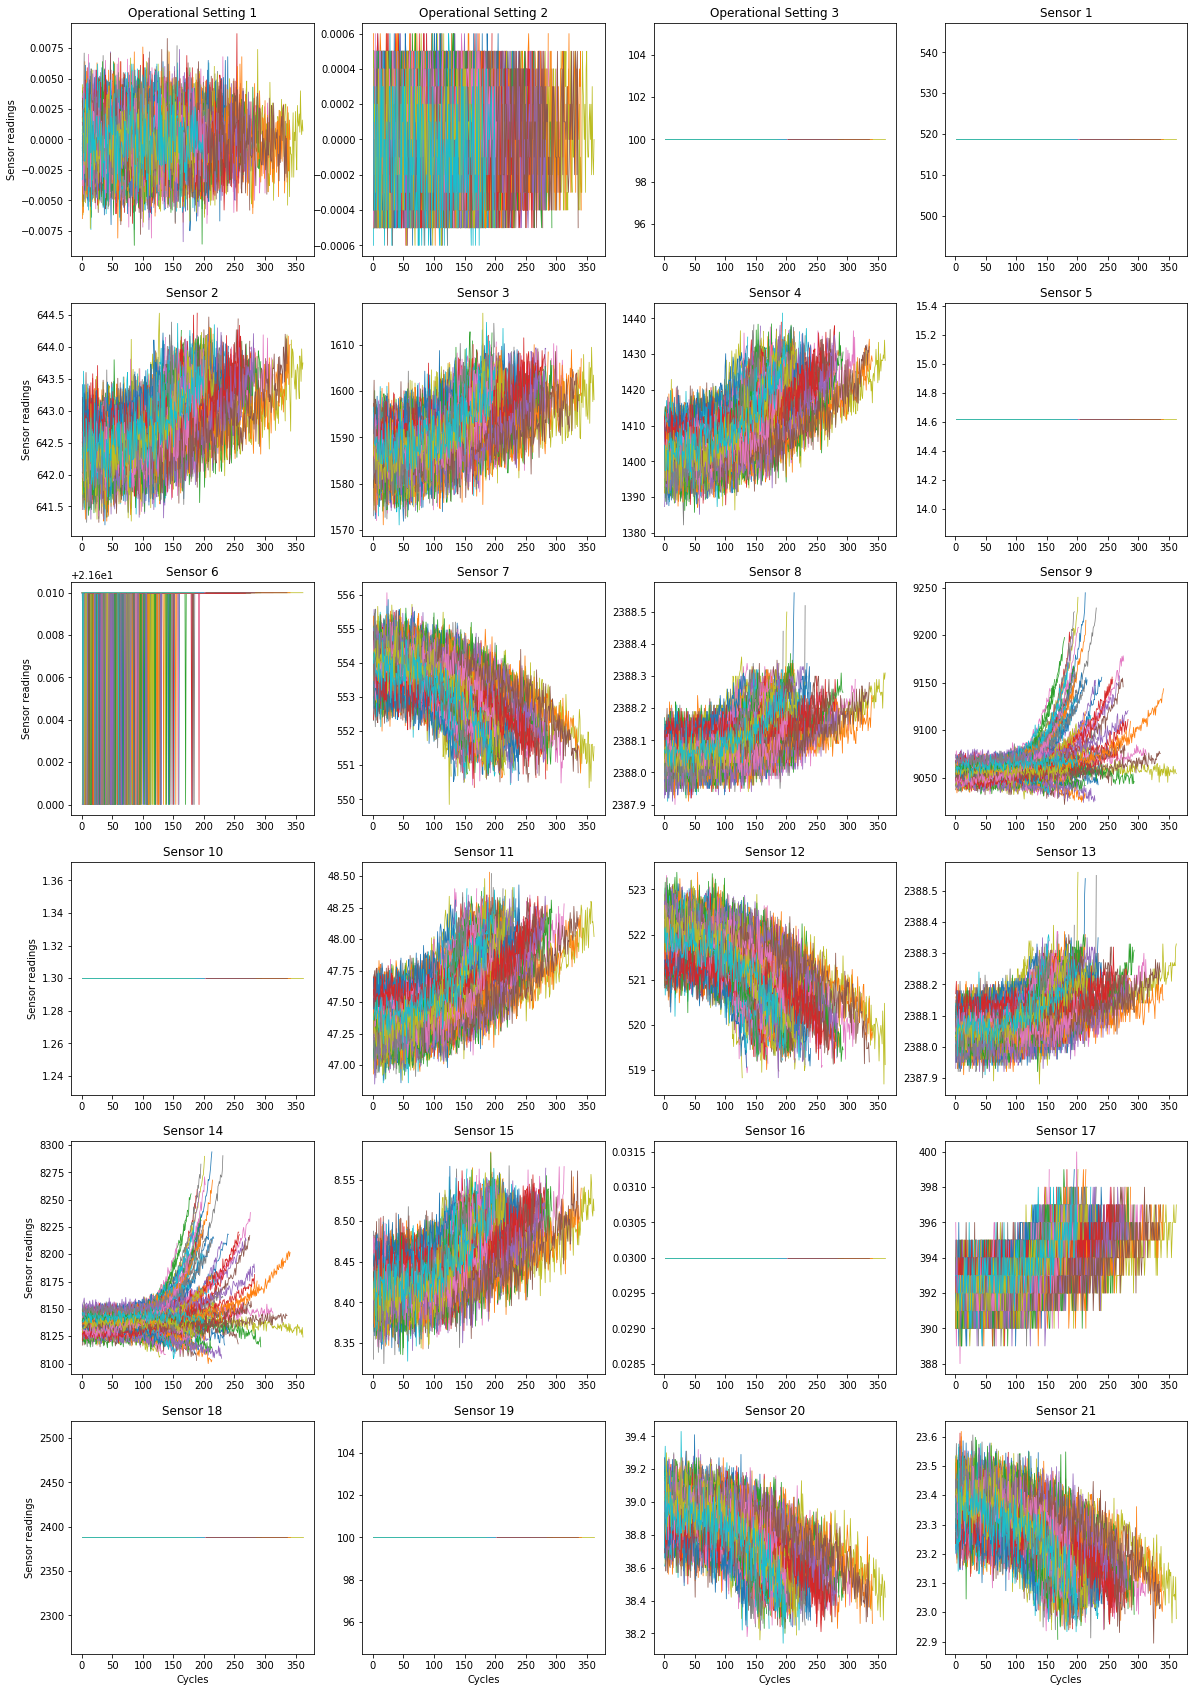

In [6]:
graph_head = ["Operational Setting 1", "Operational Setting 2", "Operational Setting 3"]
for i in range(0, 21):
    name = "Sensor "
    name = name + str(i+1)
    graph_head.append(name)

graphing_list = header[2:]
fig, axs = plt.subplots(int(len(graphing_list)/4), 4)  # row, col
i = -1
for ax in axs.flatten():
    i += 1
    ax.set_title(str(graph_head[i]))
    for engine in range(1, 101):
        df_engine = df_train_001[df_train_001['unit num'] == engine]
        ax.plot(df_engine['cycle'], df_engine[graphing_list[i]], linewidth=0.75)
        
plt.setp(axs[-1, :], xlabel='Cycles')
plt.setp(axs[:, 0], ylabel='Sensor readings')
fig.set_size_inches(20, 30)  # width x height
plt.show()

# Select useful sensor signals using MannKendall

In [7]:
# extract mean trend
no_columns = 21
up_sensor_values = np.empty([max(avg_cycle), no_columns]) # 26 sensors with a max cycle of 362
lo_sensor_values = np.empty([max(avg_cycle), no_columns]) # 26 sensors with a max cycle of 362
for col in range(0, no_columns):
    sensor = 'sens'
    sensor = sensor + str(col+1)
    for row in range(0, max(avg_cycle)):
        df_train_sens = df_train_001[df_train_001['cycle'] == row+1]
        
        # find max and min value of a sensor for each cycle
        max_value = df_train_sens.loc[df_train_sens[sensor].idxmax()]
        min_value = df_train_sens.loc[df_train_sens[sensor].idxmin()]
        
        # store max and min value
        up_sensor_values[row, col] = max_value[sensor]
        lo_sensor_values[row, col] = min_value[sensor]
mean_trend = (up_sensor_values + lo_sensor_values)/2

In [8]:
# not used as it doesnt work!
def monotonicity(sensor_number, mean_trend):
    sensor_number -= 1
    num_rows, num_cols = mean_trend.shape
    LHS = []
    RHS = []
    for t in range(0, num_rows):
        if(t == num_rows-1):
            break
        LHS.append(np.sign(mean_trend[t+1, sensor_number] - mean_trend[t, sensor_number]))
        RHS.append(np.sign(mean_trend[t, sensor_number] - mean_trend[t+1, sensor_number]))
    #print([a_i + b_i for a_i, b_i in zip(LHS, RHS)])
    return abs(sum(LHS) - sum(RHS))/(num_rows-1)

In [9]:
# Use MannKendall Trend Analysis
# https://pypi.org/project/pymannkendall/
# https://www.statisticshowto.com/wp-content/uploads/2016/08/Mann-Kendall-Analysis-1.pdf
import pymannkendall as mk
mono = []
def MannKendall(sensor_number, mean_trend, p_value=False):
    sensor_number -= 1
    trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test([row[sensor_number] for row in mean_trend], alpha=0.05)
    if p_value:
        print("{:e}".format(var_s))
    return s

<function matplotlib.pyplot.show(*args, **kw)>

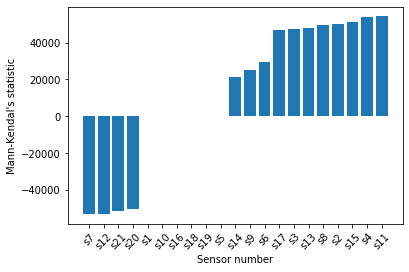

In [10]:
mono = []

# make x label for graphing
sensor_header = []
for i in range(0, 21):
    name = "s"
    name = name + str(i+1)
    sensor_header.append(name)

# retrieve y axis reading
for i in range(1, no_columns+1):
    mono.append(MannKendall(i, mean_trend))

y,x = zip(*sorted(zip(mono,sensor_header)))
plt.bar(x, y)
plt.xlabel("Sensor number")
plt.ylabel("Mann-Kendal's statistic")
plt.xticks(rotation=45)
plt.show
# Based on MannKendall, sensors 2, 3, 4, 7, 8, 11, 12, 13, 15, 17, 20 and 21 are selected


# Graphing trended results

In [11]:
rul_rf_train_std = pd.read_csv('Dataset\\processed\\rul_rf_train_std_poly.csv', sep=',')
rul_rf_train_std_poly = pd.read_csv('Dataset\\processed\\rul_rf_train_std.csv', sep=',')

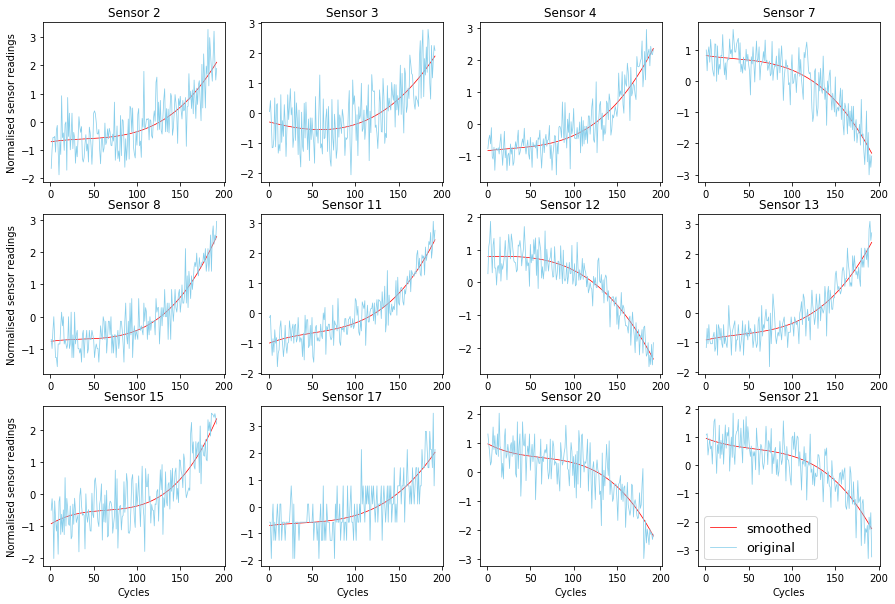

In [12]:
# plot line graph
col = list(rul_rf_train_std.columns)[2:14]
fig, axs = plt.subplots(int(len(col)/4), 4)  # row, col

unit = 1
i = 0
for ax in axs.flatten():
    ax.set_title("Sensor " + str(col[i])[4:])
    
    # plot normalised data
    ax.plot(rul_rf_train_std.loc[rul_rf_train_std['unit num'] == unit, 'cycle'],
            rul_rf_train_std.loc[rul_rf_train_std['unit num'] == unit, col[i]],
            linewidth = 0.75, color="red", label='smoothed')
    
    # plot smoothened normalised data
    ax.plot(rul_rf_train_std_poly.loc[rul_rf_train_std_poly['unit num'] == unit, 'cycle'],
            rul_rf_train_std_poly.loc[rul_rf_train_std_poly['unit num'] == unit, col[i]],
            linewidth = 0.75, color="skyblue", label='original')
    i += 1
plt.setp(axs[-1, :], xlabel='Cycles')
plt.setp(axs[:, 0], ylabel='Normalised sensor readings')
plt.legend(prop={'size': 13})
fig.set_size_inches(15, 10)  # width x height
plt.show()

# Time series clustering

In [13]:
rul_rf_trended = pd.read_csv('Dataset\\processed\\rul_rf_train_trended.csv', sep=',')

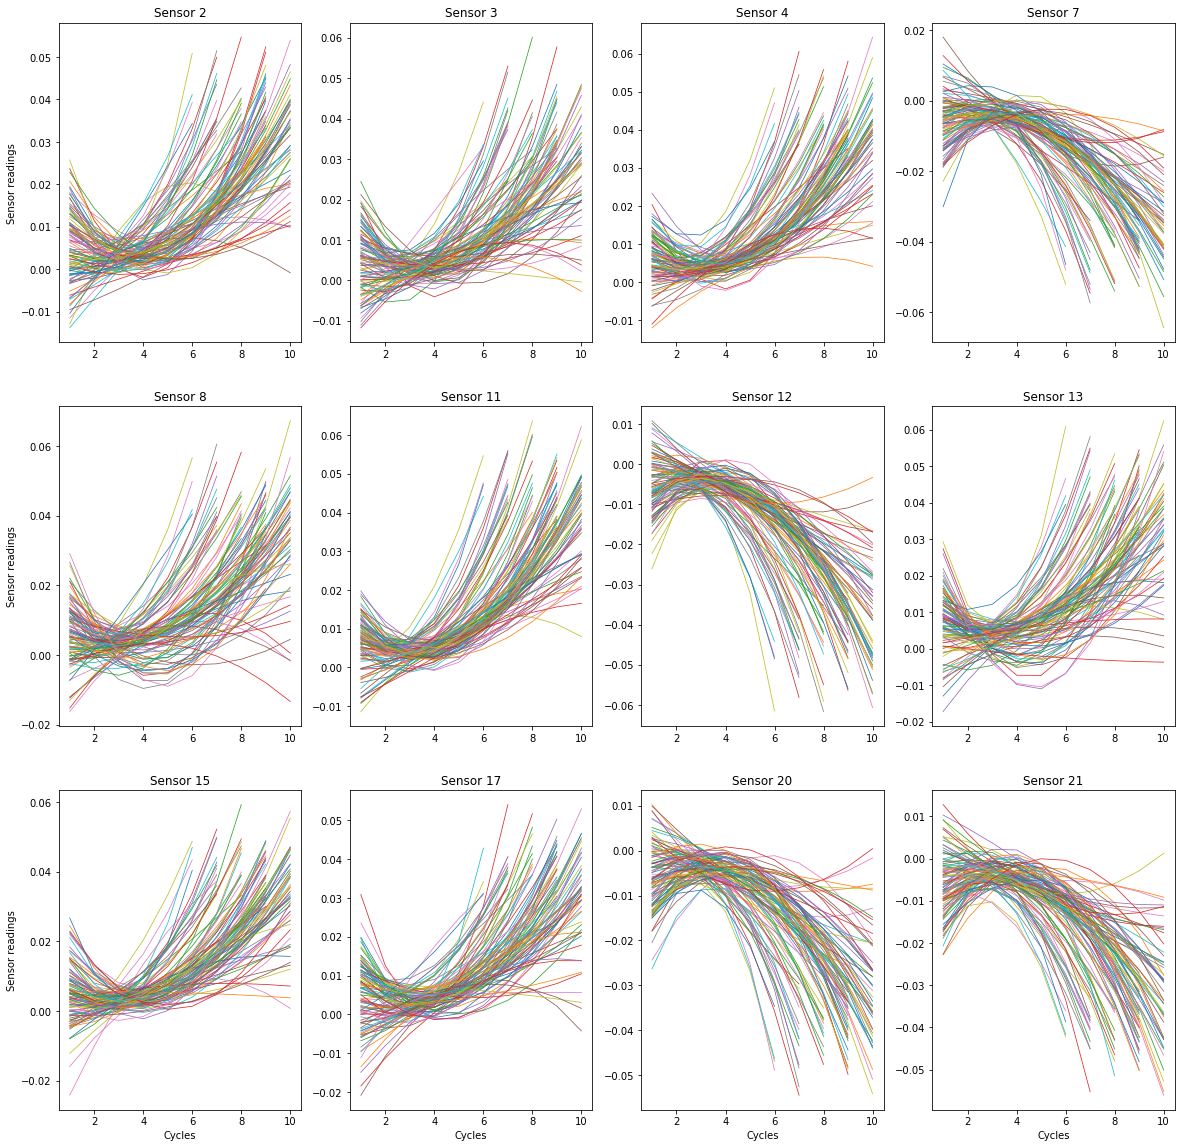

In [14]:
graph_head = []
for i in [2,3,4,7,8,11,12,13,15,17,20,21]:
    name = "Sensor "
    name = name + str(i)
    graph_head.append(name)

graphing_list = rul_rf_trended.columns.values[12:24]
fig, axs = plt.subplots(int(len(graphing_list)/4), 4)  # row, col
i = -1
for ax in axs.flatten():
    i += 1
    ax.set_title(str(graph_head[i]))
    for engine in range(1, 101):
        df_engine = rul_rf_trended[rul_rf_trended['unit num'] == engine]
        ax.plot(range(1,len(df_engine[graphing_list[i]])+1), df_engine[graphing_list[i]], linewidth=0.75)
        
plt.setp(axs[-1, :], xlabel='Cycles')
plt.setp(axs[:, 0], ylabel='Sensor readings')
fig.set_size_inches(20, 20)  # width x height
plt.show()

In [15]:
# https://towardsdatascience.com/how-to-apply-hierarchical-clustering-to-time-series-a5fe2a7d8447

# Step 1: Reshape data
clipped = 7
rul_rf_trended_clipped = rul_rf_trended[rul_rf_trended['window num'] <= clipped].copy()  # make all time series the same length
sel_sensor = "sens7_trend"
cluster_list = []
for engine in range(1, 101):
    df_temp = rul_rf_trended_clipped[rul_rf_trended_clipped['unit num'] == engine]
    cluster = []
    cluster.append(df_temp[sel_sensor])
    cluster_list.append(cluster)  
df_cluster = pd.DataFrame(cluster_list)
df_cluster.columns = ['dim_0']
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dim_0   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


In [16]:
# Step 2: Compute distance matrix
# Reshape the data so each series is a column and call the dataframe.corr() function 
distance_matrix = pd.concat([series for series in df_cluster['dim_0'].values], axis=1).corr()

series_list = df_cluster['dim_0'].values
for i in range(len(series_list)):
    length = len(series_list[i])
    series_list[i] = series_list[i].values.reshape((length, 1))

# Initialize distance matrix
n_series = len(series_list)
distance_matrix = np.zeros(shape=(n_series, n_series))

# Build distance matrix
for i in range(n_series):
    for j in range(n_series):
        x = series_list[i]
        y = series_list[j]
        if i != j:
            dist = dtw_distance(x, y)
            distance_matrix[i, j] = dist

C:\Users\chanzl_thinkpad\anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:364: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


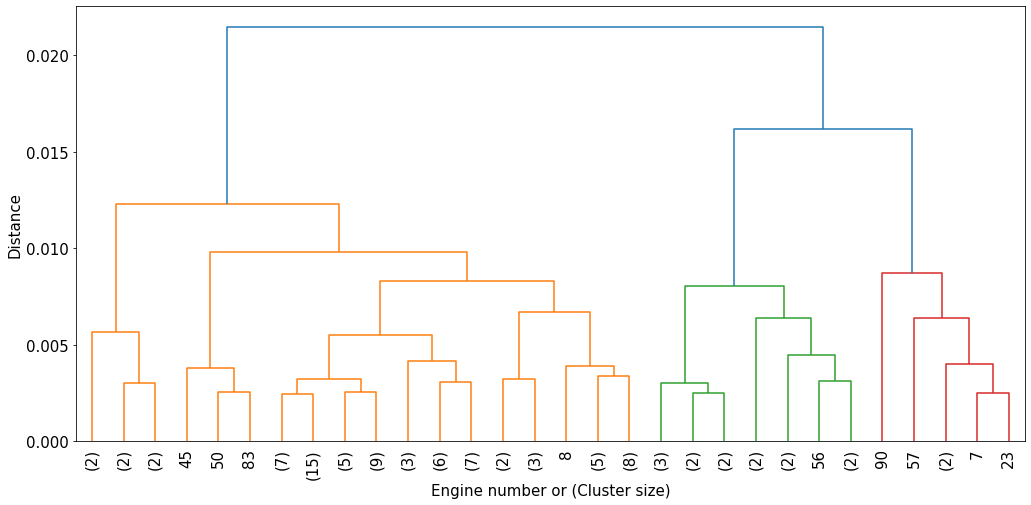

In [17]:
# Step 3: Build a linkage matrix
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram

def hierarchical_clustering(dist_mat, method='complete'):
    if method == 'complete':
        Z = complete(dist_mat)
    if method == 'single':
        Z = single(dist_mat)
    if method == 'average':
        Z = average(dist_mat)
    if method == 'ward':
        Z = ward(dist_mat)
    
    fig = plt.figure(figsize=(17, 8))  # width x height
    dn = dendrogram(Z, truncate_mode='lastp')
    ax = plt.gca()
    ax.tick_params(axis='x', which='major', labelsize=15, labelrotation=90)
    ax.tick_params(axis='y', which='major', labelsize=15)
    plt.xlabel('Engine number or (Cluster size)', fontsize=15)
    plt.ylabel('Distance', fontsize=15)
    plt.show()
    
    return Z

linkage_matrix = hierarchical_clustering(distance_matrix)

In [18]:
# Step 4: Create clusters
from scipy.cluster.hierarchy import fcluster

# select maximum number of clusters
cluster_labels_num = fcluster(linkage_matrix, 3, criterion='maxclust')
bb=dict(zip(list(cluster_labels_num),[list(cluster_labels_num).count(i) for i in list(cluster_labels_num)]))
print(bb)

# hand-select an appropriate cut-off on the dendrogram
# cluster_labels_sel = fcluster(linkage_matrix, 0.0100, criterion='distance')
# print(cluster_labels_sel)

{1: 80, 3: 6, 2: 14}


In [19]:
# add cluster results back to original df
rul_rf_trended["cluster"] = [cluster_labels_num[i-1] for i in rul_rf_trended['unit num']]

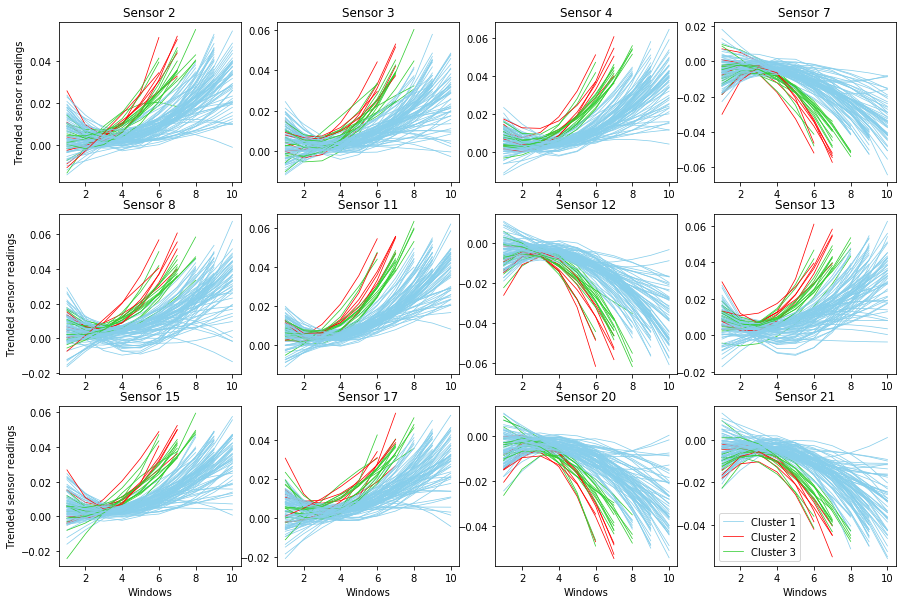

In [20]:
# graph clusters
# https://matplotlib.org/stable/gallery/color/named_colors.html
colour = ['skyblue', 'limegreen', 'red', 'black', 'pink']  # colour for each of the clusters
cluster_label = ['Cluster 1', 'Cluster 3', 'Cluster 2', 'Cluster 4']

graphing_list = rul_rf_trended.columns.values[12:24]
fig, axs = plt.subplots(int(len(graphing_list)/4), 4)  # row, col
i = -1
for ax in axs.flatten():
    i += 1
    ax.set_title(str(graph_head[i]))
    for engine in range(1, 101):
        df_engine = rul_rf_trended[rul_rf_trended['unit num'] == engine]
        cluster_no = df_engine['cluster'].iloc[0] - 1
        ax.plot(range(1,len(df_engine[graphing_list[i]])+1), df_engine[graphing_list[i]], 
                linewidth=0.75, color=colour[cluster_no], label=cluster_label[cluster_no])

# to format legend. do not delete
handles, labels = plt.gca().get_legend_handles_labels()
i =1
while i<len(labels):
    if labels[i] in labels[:i]:
        del(labels[i])
        del(handles[i])
    else:
        i +=1
        
plt.setp(axs[-1, :], xlabel='Windows')
plt.setp(axs[:, 0], ylabel='Trended sensor readings')
plt.legend(handles, labels)
fig.set_size_inches(15, 10)  # width x height
plt.show()